# Modeling and the Temperature of the Earth with the Atmosphere using Absorption Spectra Data

In [108]:
# Import Libraries
import pandas as pd
import math
import numpy as np
from typing import Callable
import functools
import bisect
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from Unit0 import model_utils

In [109]:
# Constants
plancks_constant = 6.62607015e-34
speed_of_light = 299792458
boltzmann_constant = 1.380649e-23

absorption_components = ["H2O", "CO2", "CH4", "O3", "N2O", "N2", "O2"]
wavelengths = np.linspace(0.1e-6, 40e-6, 399001)
temperature_sun = 5772

In [110]:
# Define Calculation Functions
def plancks_law(wavelength: float, temperature: float):
    return 2 * plancks_constant * speed_of_light ** 2 / wavelength ** 5 / math.expm1(plancks_constant * speed_of_light / wavelength / boltzmann_constant / temperature)


def spectral_radiance(wavelength: float, temperature: float, transmittances_for_wavelength: list[float]) -> float:
    return plancks_law(wavelength, temperature) * functools.reduce(lambda x, y: x * y, transmittances_for_wavelength)


def radiance(wavelengths: list[float], temperature: float, transmittances: list[list]) -> float:
    delta_wavelength = wavelengths[1] - wavelengths[0]
    return functools.reduce(lambda x, y: x + y, [spectral_radiance(wavelength, temperature, transmittances_for_wavelength) * delta_wavelength for wavelength, transmittances_for_wavelength in zip(wavelengths, transmittances)])

In [111]:
# Load Data
data1 = pd.read_csv("Data/Absorption 0.1-3 Microns.csv")
data2 = pd.read_csv("Data/Absorption 3-12 Microns.csv")
data3 = pd.read_csv("Data/Absorption 12-40 Microns.csv")

In [112]:
# Processes data into lists of tuples of wavelength and transmittance
def load_transmittance_for_component(data: pd.DataFrame, wavelength_key: str, component: str):
    return list(filter(lambda x: not math.isnan(x[0]) and not math.isnan(x[1]), zip(map(lambda x: x * 1e-6, data[wavelength_key]), data[f"{component} Transmittance"])))


transmittances = [load_transmittance_for_component(data1, f"{component} Wavelength (microns)", component) + load_transmittance_for_component(data2, "Wavelength (microns)", component) + load_transmittance_for_component(data3, "Wavelength (microns)", component) for component in absorption_components]

In [113]:
# Finds value in a less than or equal to x
def find_le[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect(a, x, key=key)
    return a[i - 1 if i else 0]


# Finds value in a greater than or equal to x
def find_ge[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect_left(a, x, key=key)
    return a[i if i < len(a) else i - 1]


# Interpolates value of x based on lower and upper bounds in a
def interpolate[K, V](a: list[tuple[K, V]], x: K) -> V:
    key: Callable[[tuple[K, V]], K] = lambda p: p[0]
    value: Callable[[tuple[K, V]], V] = lambda p: p[1]
    p0: tuple[K, V] = find_le(a, x, key)
    p1: tuple[K, V] = find_ge(a, x, key)
    x0: K = key(p0)
    x1: K = key(p1)
    y0: V = value(p0)
    if x0 == x1:
        return y0
    y1: V = value(p1)
    return y0 + (y1 - y0) / (x1 - x0) * (x - x0)

100%|██████████| 399001/399001 [00:06<00:00, 57434.49it/s]


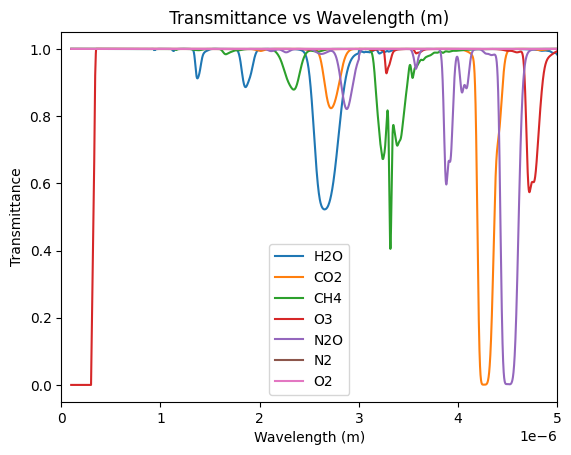

In [114]:
# Interpolate Transmittances
transmittances_interpolated = [[interpolate(transmittance, wavelength) for transmittance in transmittances] for wavelength in tqdm(wavelengths)]

plt.xlim(0, 5e-6)
model_utils.graph([(wavelengths, list(map(lambda x: x[i], transmittances_interpolated)), absorption_component) for i, absorption_component in enumerate(absorption_components)], "Transmittance", "", "Wavelength", "m")

100%|██████████| 399001/399001 [00:00<00:00, 995741.92it/s] 


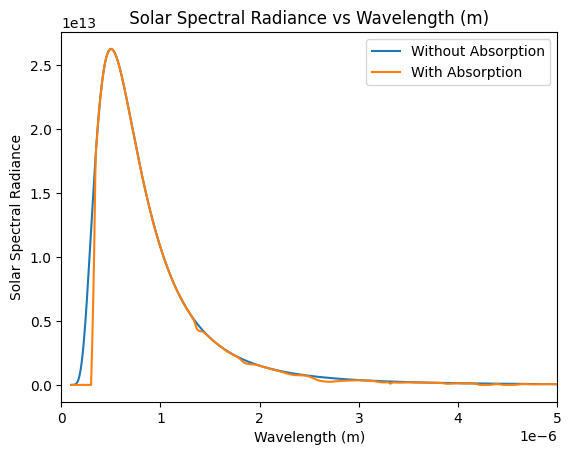

In [115]:
# Calculate Solar Spectral Radiance
solar_spectral_radiance_without_transmittances = [plancks_law(wavelength, temperature_sun) for wavelength in tqdm(wavelengths)]
solar_spectral_radiance = [spectral_radiance(wavelength, temperature_sun, transmittances_for_wavelength) for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), transmittances_interpolated)]

plt.xlim(0, 5e-6)
model_utils.graph([(wavelengths, solar_spectral_radiance_without_transmittances, "Without Absorption"), (wavelengths, solar_spectral_radiance, "With Absorption")], "Solar Spectral Radiance", "", "Wavelength", "m")